## Investigate the non-Gaussianity of SST Data from CESM


In [57]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sys
import cmocean
from tqdm import tqdm

stormtrack = 0
if stormtrack == 0:
    projpath   = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"
    datpath     = projpath + '01_Data/model_output/'
    rawpath     = projpath + '01_Data/model_input/'
    outpathdat  = datpath + '/proc/'
    figpath     = projpath + "02_Figures/20220711/"
   
    sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/")
    sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/")

elif stormtrack == 1:
    datpath     = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_output/"
    rawpath     = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/"
    outpathdat  = datpath + '/proc/'

    
    sys.path.append("/home/glliu/00_Scripts/01_Projects/00_Commons/")
    sys.path.append("/home/glliu/00_Scripts/01_Projects/01_AMV/02_stochmod/stochmod/model/")

from amv import proc,viz
import scm
import tbx
import time
import xarray as xr

from scipy.io import loadmat
from scipy import stats

In [18]:
# Load CESM-Data

# Path to data 
projpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"
outpath = projpath + '02_Figures/20220711/'
proc.makedir(outpath)
datpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/"

mconfigs = ("FULL","SLAB")
bbox     = [-80,0,10,65]
#bboxplot = 
runmean      = True
ensorem      = False # Set to True to use ENSO-removed data
enso_compare = True # Set to True to compare ENSO removal

# Use separate landice mask for each
limasks = (datpath+"CESM-FULL_landicemask360.npy",
           datpath+"CESM-SLAB_landicemask360.npy"
           )

/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/02_Figures/20220711/ was found!


In [19]:
def preproc_CESMPIC_ds(sst,limask=None):
    
    # Apply Land/Ice Mask
    if limask is None:
        mask = np.load(datpath+"landicemask_enssum.npy")
    else:
        mask = np.load(limask)
    sst = ds.TS * mask[None,:,:]
    
    # Remove monthly anomalies
    st = time.time()
    sst = proc.xrdeseason(sst) # Calculate monthly
    
    print("Deseasoned in %.2fs"%(time.time()-st))
    return sst

In [24]:
st = time.time()
# Load full sst data from model # [time x lat x lon]
if enso_compare:
    ssts_all = [] # [yes/no enso][full,slab]
    
    for e in range(2): # Loop for without and with ENSO
        
        ssts = []
        if e == 0: # Load in TS with ENSO removed
            fns = ("FULL_PIC_ENSOREM_TS_lag1_pcs2_monwin3.npz","SLAB_PIC_ENSOREM_TS_lag1_pcs2_monwin3.npz")
            for r in range(2):
                ld = np.load(datpath+fns[r],allow_pickle=True)
                ssts.append(ld['TS'])
        
        elif e == 1: # Load in TS with ENSO present, and preprocess
            
            for r in range(2):
                # Load in the dataset
                ds = xr.open_dataset(datpath+"CESM_proc/"+"TS_anom_PIC_%s.nc"%(mconfigs[r]))
                # Calculate anomaly and apply land mask
                dsout = preproc_CESMPIC_ds(ds,limask=limasks[i])
                ssts.append(dsout.values)
        
        ssts_all.append(ssts)
else:
    if ensorem: # Load full field with ENSO removed
        ld  = np.load(datpath+"FULL_PIC_ENSOREM_TS_lag1_pcs2_monwin3.npz" ,allow_pickle=True)
        sstfull = ld['TS']
        ld2 = np.load(datpath+"SLAB_PIC_ENSOREM_TS_lag1_pcs2_monwin3.npz" ,allow_pickle=True)
        sstslab = ld2['TS']
        remove_anom=True
    else: # Load anomalies without ENSO removal (~82 sec)
        ssts     = []
        mconfigs = ["FULL","SLAB"]
        for i in range(2):
            ds = xr.open_dataset(datpath+"CESM_proc/"+"TS_anom_PIC_%s.nc"%(mconfigs[i]))
            #sst = ds.TS.values
            ssts.append(ds)
            #ssts.append(sst)
        sstfull,sstslab = ssts
        remove_anom=False

# Load lat/lon
lat    = loadmat("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/01_Data/CESM1_LATLON.mat")['LAT'].squeeze()
lon360 = loadmat("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/01_Data/CESM1_LATLON.mat")['LON'].squeeze()

print("Loaded PiC Data in %.2fs"%(time.time()-st))

Deseasoned in 53.17s
Deseasoned in 13.57s
Loaded PiC Data in 171.02s


In [46]:
# Load masks for usage below
masks = []
for mc in range(2):
    masks.append(np.load(limasks[mc]))
#masks[0].shape
    


(192, 288)

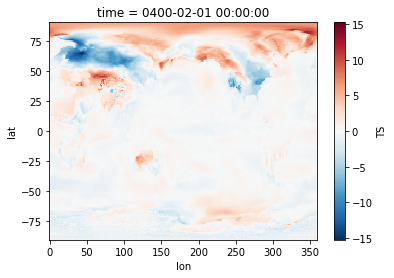

In [16]:
ssts[0].isel(time=0).TS.plot()

In [8]:
%%time

ssta = []
for i in range(2):
    dsin  = ssts[i]
    dsout = preproc_CESMPIC_ds(dsin,limask=limasks[i])
    ssta.append(dsout)
    

Deseasoned in 13.13s
Deseasoned in 11.39s
CPU times: user 37.3 s, sys: 15.2 s, total: 52.5 s
Wall time: 53.1 s


In [ ]:




ssta[0].isel(time=9).plot()

In [ ]:
skewtest = stats.skew(ssta[0],axis=0)

In [ ]:
ssta[0].shape,skewtest.shape

In [ ]:
mconfig = 1


skewtest = stats.skew(ssta[mconfig],axis=0)
lon  = np.linspace(0,360,288)
lat  = np.linspace(-90,90,192)
vmax = 1
cstep = 0.05
clvl = np.arange(-vmax,vmax+cstep,cstep)
proj = ccrs.PlateCarree()
#bbox = [0,360,-65,65]

fig,ax = plt.subplots(1,1,figsize=(10,6),subplot_kw={'projection':proj})
ax = viz.add_coast_grid(ax,proj=proj)
#pcm = ax.pcolormesh(lon,lat,skewtest,vmin=-vmax,vmax=vmax,cmap=cmocean.cm.balance)
pcm = ax.contourf(lon,lat,skewtest,levels=clvl,cmap=cmocean.cm.balance)
fig.colorbar(pcm,ax=ax,fraction=0.025)
ax.set_title("SST' Skewness (CESM Preindustrial Control)")

plt.savefig("SST Skewness.png",dpi=200,bbox_inches='tight')

## Compute Skew for all cases and Compare ENSO Removal effect

In [37]:
# Compute Skew
skewsst       = []
skewsst_names = ("FULL (no ENSO)","SLAB (no ENSO)",
                 "FULL (with ENSO)", "SLAB (with ENSO)")
enames = ("no ENSO","with ENSO")

for e in range(2):
    skews = []
    for mc in range(2):
        sst = ssts_all[e][mc]
        skews.append(stats.skew(sst,axis=0))
        print(sst.shape)
    skewsst.append(skews)
        


#skewtest = stats.skew(ssta[0],axis=0)

(21576, 192, 288)
(10776, 192, 288)
(21612, 192, 288)
(10812, 192, 288)


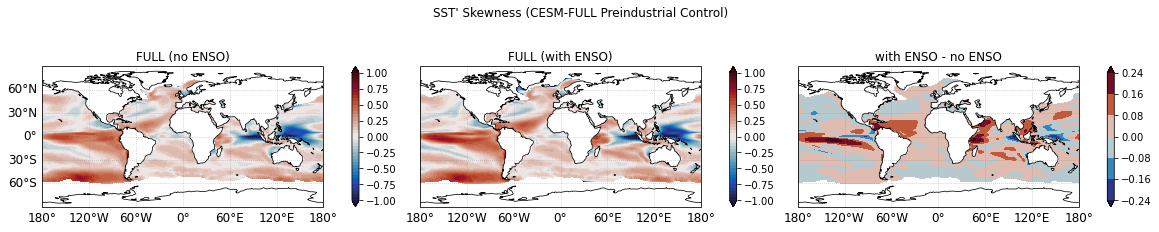

In [62]:
# Now Plot the Differences
enames = ("no ENSO","with ENSO")

mconfig = 0

#skewtest = stats.skew(ssta[mconfig],axis=0)
lon  = np.linspace(0,360,288)
lat  = np.linspace(-90,90,192)
vmax = 1
cstep = 0.05
clvl = np.arange(-vmax,vmax+cstep,cstep)
proj = ccrs.PlateCarree()
#bbox = [0,360,-65,65]


fig,axs = plt.subplots(1,3,figsize=(16,4),subplot_kw={'projection':proj},constrained_layout=True)

for a in range(3):
    ax = axs[a]
    blabels = [0,0,0,1]
    if a == 0:
        blabels[0]=1
    ax = viz.add_coast_grid(ax,proj=proj,blabels=blabels)
    
    if a < 2:
        plotvar = (skewsst[a][mconfig]) * masks[a][:,:]
        title   = "%s (%s)" % (mconfigs[mconfig],enames[a]) 
        clvl = np.arange(-vmax,vmax+cstep,cstep)
        pcm = ax.contourf(lon,lat,plotvar,levels=clvl,cmap=cmocean.cm.balance,extend='both')
    else:
        plotvar = skewsst[1][mconfig] - skewsst[0][mconfig]
        title   = "%s - %s" % (enames[1],enames[0])
        pcm = ax.contourf(lon,lat,plotvar,cmap=cmocean.cm.balance,extend='both')
        
        #clvl = np.arange(-.01,.01+0.005,0.005)
                                           
    #pcm = ax.pcolormesh(lon,lat,skewtest,vmin=-vmax,vmax=vmax,cmap=cmocean.cm.balance)
    #pcm = ax.contourf(lon,lat,plotvar,levels=clvl,cmap=cmocean.cm.balance)
    fig.colorbar(pcm,ax=ax,fraction=0.025)
    ax.set_title(title)
plt.suptitle("SST' Skewness (CESM-%s Preindustrial Control)" % mconfigs[mconfig],y=.95)

plt.savefig("%sSST_Skewness_EnsoCompare_CESM%s.png"%(figpath,mconfigs[mconfig]),dpi=200,bbox_inches='tight')

In [50]:
masks[a][None,:,:].shape


(1, 192, 288)

In [55]:
figpath

'/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/02_Figures/20220714/'